In [2]:
"""
Copied from https://raw.githubusercontent.com/goossaert/algorithms/master/simulated_annealing/annealing.py
---
Simulated annealing with restart applied to the traveling salesman problem.

The data needs to be in cvs format and the coordinates of the cities are
longitude and latitude. Thus, any gps data taken on the internet can
serve as input.

Once the annealing is done, the cities are plotted according to their
coordinates using the matplotlib package. The cities are then linked as to
show the order of visit in the final solution. Also, the evolution of the
tested and shortest distances is plotted.
"""

__docformat__ = "restructuredtext en" 

## Copyright (c) 2010 Emmanuel Goossaert 
##
## This file is free software; you can redistribute it and/or modify
## it under the terms of the GNU General Public License as published by
## the Free Software Foundation; either version 3 of the License, or
## (at your option) any later version.
##
## This file is distributed in the hope that it will be useful,
## but WITHOUT ANY WARRANTY; without even the implied warranty of
## MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
## GNU General Public License for more details.
##
## You should have received a copy of the GNU General Public License
## along with this file.  If not, see <http://www.gnu.org/licenses/>.



In [1]:
import pandas as pd 

import sys
import math
import random
import time

import matplotlib.pyplot as plt


INITIAL TOUR: 


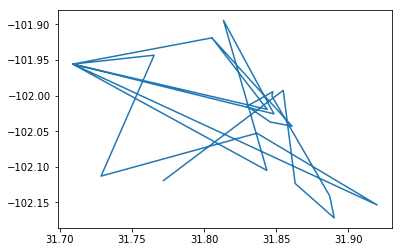

|--15--5--21--20--19--3--16--7--4--17--25--6--12--22--24--18--9--2--8--11--14--13--10--23 412.99899


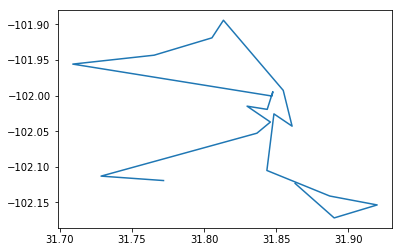

|--15--11--8--4--7--6--16--3--12--9--10--13--14--23--25--24--5--17--18--22--19--2--20--21 142.01992


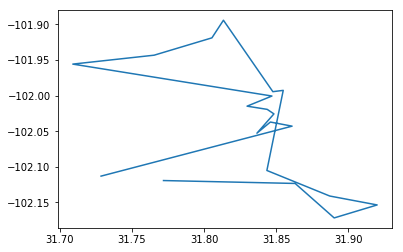

|--15--21--20--2--19--22--5--16--24--25--23--13--14--9--12--10--3--7--6--18--8--4--17--11 141.96518


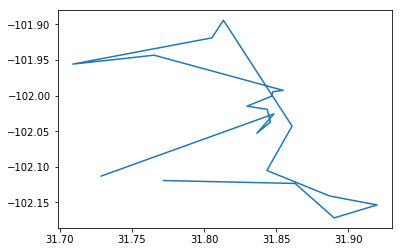

|--15--21--20--2--19--22--17--24--25--23--9--10--12--14--13--5--16--3--7--6--4--8--18--11 140.99989


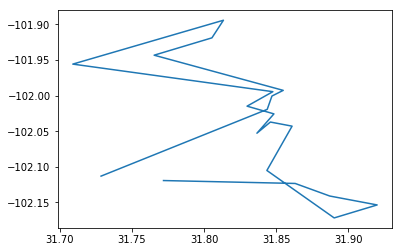

|--15--21--19--2--20--22--17--4--8--18--7--16--10--9--12--24--25--23--14--13--5--3--6--11 138.55245


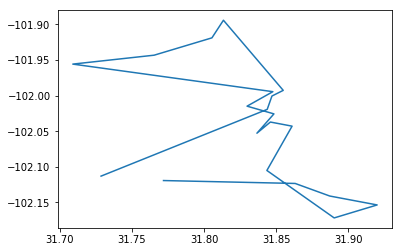

|--15--21--19--2--20--22--17--4--8--18--7--16--9--10--12--14--13--25--23--24--5--3--6--11 133.71869


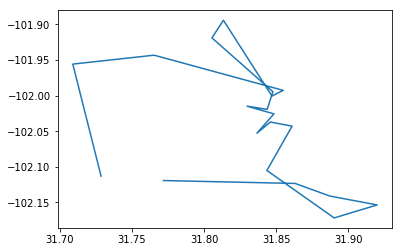

|--15--21--19--2--20--22--17--4--8--18--7--6--16--25--23--24--3--5--14--13--10--12--9--11 124.91091


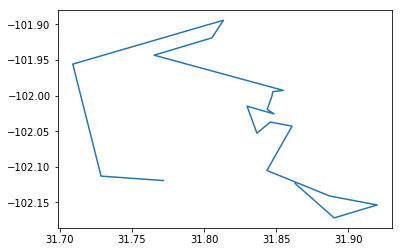

|--15--11--9--12--10--24--25--23--14--13--5--16--3--6--18--7--8--4--17--22--19--2--20--21 120.70793


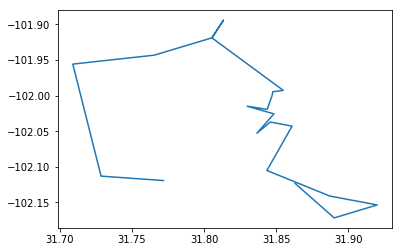

|--15--11--10--9--12--13--14--23--24--25--5--16--3--6--7--18--8--4--17--22--19--2--20--21 114.05442


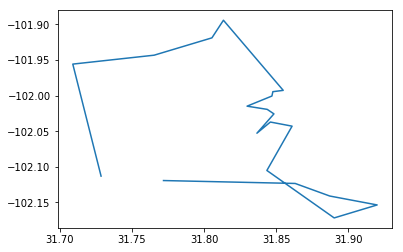

|--15--21--19--2--20--22--17--4--8--18--6--7--3--16--5--24--23--25--13--14--9--10--12--11 113.47775


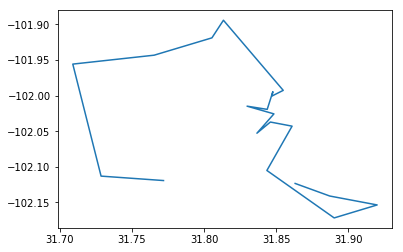

|--15--11--12--10--9--14--13--25--23--24--5--3--16--6--7--18--8--4--17--22--20--2--19--21 113.47774
Wall time: 23min 16s


In [8]:
%%time

COOLING_FACTOR =.99
TEMPERATURE_START = 1.0e+10
TEMPERATURE_END  = 0.0001
RANDOM_SEED      = 43

NUMBER_OF_ITERATIONS = 10000

TOTAL_WORK_DAY_MIN = 9*60
TOTAL_DAY_MIN = 24*60
WAREHOUSE_ID = 1

class City:
    def __init__(self, Id=0, x=None, y=None, priority=None, target_dt=None, est_exec_time=None):
        self.Id = 0
        self.Priority= 0
        ##meaning number of days from today
        self.Target_date= 0
        ## to clarify if the exec time can be more than 9 hrs
        self.Estimated_execution_time = 0
        self.timeToWarehouse = 0
        self.distanceToWarehouse = 0
        self.x = None
        self.y = None
        if Id is not None:
            self.Id = Id
            self.timeToWarehouse = Travel_times[(self.Id,WAREHOUSE_ID)]
            self.distanceToWarehouse = Travel_distances[(self.Id,WAREHOUSE_ID)]
        if priority is not None:
            self.Priority = random.randint(1,4)
            #self.Priority = priority
        if target_dt is not None:
            self.Target_date = random.randint(1,10)
            #self.Target_date = target_dt
        if est_exec_time is not None:
            self.Estimated_execution_time = random.randint(1,9)
            #self.Estimated_execution_time =est_exec_time
                    
        if x is not None:
            self.x = x
        if y is not None:
            self.y = y

    def getX(self):
        return self.x
   
    def getY(self):
        return self.y
   
    def distanceTo(self, city):
        ## in our case distance is pre-calculated and available from the Dict
        distance = Travel_distances[(self.Id, city.Id)]
        return distance

    def timeTo(self, city):
        time = Travel_times[(self.Id, city.Id)]
        return time
   
    def __repr__(self):
        return str(self.getX()) + ", " + str(self.getY())


class TourManager:
    destinationCities = []
   
    def addCity(self, city):
        self.destinationCities.append(city)
    
    def getCity(self, index):
        return self.destinationCities[index]
    
    def numberOfCities(self):
        return len(self.destinationCities)


class Tour:
    def __init__(self, tourmanager):
        self.tourmanager = tourmanager
        self.tour = []
        self.fitness = 0.0
        self.priorities = 0
        self.time = 0
        for i in range(0, self.tourmanager.numberOfCities()):
            self.tour.append(None)
        self.generateIndividual()
        
    def __len__(self):
        return len(self.tour)
   
    def __getitem__(self, index):
        return self.tour[index]
   
    def __setitem__(self, key, value):
        self.tour[key] = value

    def __repr__(self):
        geneString = "|"
        tour_x = []
        tour_y = []
        for i in range(0, self.tourSize()):
            city = self.getCity(i)
            geneString += "--" +str(city.Id)
            tour_x.append(city.getX())
            tour_y.append(city.getY())
        fig = plt.figure()
        plt.plot(tour_x, tour_y)
        plt.show()
        return geneString

    def generateIndividual(self):
        for cityIndex in range(0, self.tourmanager.numberOfCities()):
            self.setCity(cityIndex, self.tourmanager.getCity(cityIndex))
        random.shuffle(self.tour)

    def getCity(self, tourPosition):
        return self.tour[tourPosition]

    def setCity(self, tourPosition, city):
        self.tour[tourPosition] = city

    def getFitness(self):
        if self.fitness == 0:
            self.fitness = self.getScore()
        return self.fitness
    
#     def getScoreSimpleDistance
    def getScore(self):
        tourDistance = 0
        tourTime = 0
        tourPriorities = 0

        _tourSize = self.tourSize()
        for cityIndex in range(0, _tourSize):
            fromCity = self.getCity(cityIndex)
            destinationCity = None
            if cityIndex+1 < _tourSize:
                destinationCity = self.getCity(cityIndex+1)
            else:
                destinationCity = self.getCity(0)

            tripDistance = fromCity.distanceTo(destinationCity)
            tripTime = fromCity.timeTo(destinationCity)

            tourDistance += tripDistance 
            tourTime = tripTime

        
        self.distance = tourDistance
        self.time = tourTime
        return self.distance

    def getScore_correct(self):
        ##correlation coeff ~0.87 and p-value = 0 indicates that time and distance are indeed correlated
        ##TODO: Thus, we will concentrate on Time only f(priority, time)
        #tourDistance = 0
        tourTime = 0
        tourPriorities = 0

        #Add distance, time from the warehouse to the first point 
        #tourDistance += self.getCity(0).distanceToWarehouse
        tourTime += self.getCity(0).timeToWarehouse

        _tourSize = self.tourSize()
        for cityIndex in range(0, _tourSize):
            fromCity = self.getCity(cityIndex)
            destinationCity = None
            if cityIndex+1 < _tourSize:
                destinationCity = self.getCity(cityIndex+1)
            else:
                destinationCity = self.getCity(0)

            #tripDistance = fromCity.distanceTo(destinationCity)
            tripTime = fromCity.timeTo(destinationCity)

            if tourTime + tripTime <= TOTAL_WORK_DAY_MIN:
                #tourDistance += tripDistance
                tourTime += tripTime + destinationCity.Estimated_execution_time
            else:
                # if we can't complete the next WO today count as full day + time until the next morning
                # so go back to warehouse, add time to come back to the field 
                #tourDistance += fromCity.distanceToWarehouse + destinationCity.distanceToWarehouse 
                tourTime = TOTAL_DAY_MIN + destinationCity.timeToWarehouse + destinationCity.Estimated_execution_time
                #tourDistance += fromCity.timeToWarehouse + destinationCity.timeToWarehouse + destinationCity.Estimated_execution_time

        #Add distance from the last point to the warehouse 
        #tourDistance += self.getCity(_tourSize-1).distanceToWarehouse
        tourTime += self.getCity(_tourSize-1).timeToWarehouse

        #self.distance = tourDistance
        self.time = tourTime
        return self.time

    def tourSize(self):
        return len(self.tour)

    def containsCity(self, city):
        return city in self.tour
    
    def swapCities(self, city_index_1, city_index_2):
        buf = self.getCity(city_index_1)
        self.setCity(city_index_1, self.getCity(city_index_2))
        self.setCity(city_index_2, buf)

class Annealing:
    def __init__(self, tour):
        self.tour = tour.generateIndividual()

    def anneal(self, tour):
        temperature = TEMPERATURE_START
        best_tour = tour
        best_score= best_tour.getScore()
        step =0
        while temperature > TEMPERATURE_END:
            # compute the indices of the two cities to swap by random,
            city_index_1 = random.randint(1, tour.tourSize()-1)
            city_index_2 = random.randint(1, tour.tourSize()-1)
            tour.swapCities(city_index_1,city_index_2)

            # compute the new distance
            # acceptance probability by Kirkpatrick et al.
            new_score = tour.getScore()
            diff = new_score - best_score
            if diff < 0 or  math.exp( -diff / temperature ) > random.random():
                best_tour = tour
                best_score = new_score
            else:
                tour.swapCities(city_index_1,city_index_2)

            temperature = temperature * COOLING_FACTOR
            step = step + 1
        return best_tour
        
if __name__ == '__main__':
    
    tourmanager = TourManager()
    # Create and add our cities
    cities = df[['Origin OID','Latitude','Longitude']].groupby(['Origin OID']).min().head(25)

    ##TODO: for the purpose of this example let's make the point 24 (31.8134,-101.894) the warehouse 
    for index, row in cities.iterrows():
        city = City(index,row.Latitude, row.Longitude)
        if index == WAREHOUSE_ID:
            continue
        tourmanager.addCity(city)
    tour = Tour(tourmanager)
    # Evolve population for 50 generations
    annealing = Annealing(tour)
    optTour = tour
    optScore = optTour.getScore()
    print "INITIAL TOUR: "
    print optTour, optScore

    for i in range(0, NUMBER_OF_ITERATIONS):
        tour = annealing.anneal(tour)
        if tour.getScore()<optScore:
            optTour = copy.copy(tour)
            optScore = tour.getScore()
            print optTour, optScore

# print "FINAL TOUR:"
# print optTour, optScore

In [6]:
df[['Origin OID','Latitude','Longitude']].groupby(['Origin OID']).min().head()

Latitude   Longitude
Origin OID                       
1           31.888797 -102.141314
2           31.920028 -102.153511
3           31.847056 -102.000667
4           31.845972 -102.037167
5           31.854889 -101.992722

In [3]:
import copy

In [4]:
df = pd.read_csv('Data/sampleOdessaEquipment_ODcostMatrix.csv', index_col=0)
df.head()

Destination Rank  Total Time (Minutes)  Total Distance (Miles)  \
OBJECTID                                                                   
1                        1              0.000000                 0.00000   
2                        2              0.546318                 0.11316   
3                        3              2.355701                 0.48792   
4                        4              7.441140                 1.54124   
5                        5              9.399694                 1.94690   

          Origin OID  Shape_Length     Area   Equipment_Code   Class  \
OBJECTID                                                               
1                  1      0.000000  MIDLAND  000SCRBRSEC35DF  OSESWD   
2                  1      0.001681  MIDLAND  000SCRBRSEC35DF  OSESWD   
3                  1      0.011823  MIDLAND  000SCRBRSEC35DF  OSESWD   
4                  1      0.016628  MIDLAND  000SCRBRSEC35DF  OSESWD   
5                  1      0.029634  MIDLAND  000SCRBRSEC35DF  OSESWD   

                 Class_Description  \
OBJECTID                             
1         SE - Salt Water Disposal   
2         SE - Salt Water Disposal   
3         SE - Salt Water Disposal   
4         SE - Salt Water Disposal   
5         SE - Salt Water Disposal   

                                      Equipment_Description     ...      \
OBJECTID                                                        ...       
1         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)     ...       
2         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)     ...       
3         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)     ...       
4         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)     ...       
5         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)     ...       

         Class.1       Class_Description.1  \
OBJECTID                                     
1         OSESWD  SE - Salt Water Disposal   
2         OSEBTY              SE - Battery   
3         OSEBTY              SE - Battery   
4         OSEBTY              SE - Battery   
5         OSEBTY              SE - Battery   

                                    Equipment_Description.1 Parent_Code.1  \
OBJECTID                                                                    
1         DISPOSAL; SCHARBAUER 35 SWD (AKA ELLENBERGER SWD)           OEG   
2                 BATTERY; SCHARBAUER B1 BTY  (aka B&E BTY)           PF8   
3                              BATTERY; BRYANT G SEC 26 BTY           PF8   
4                                       BATTERY; BGDU 1 BTY           PG4   
5                              BATTERY; BGDU 34 CENTRAL BTY           PF8   

         FieldOperationsTeam.1  FieldProductionTeam.1  Cost_Code.1  \
OBJECTID                                                             
1                   Odessa FOT            Odessa East    UC000LW4X   
2                   Odessa FOT            Odessa East    UCPF8JY2X   
3                   Odessa FOT            Odessa East    UCPF8J11X   
4                   Odessa FOT            Odessa East    UCPG51100   
5                   Odessa FOT            Odessa East    UCPF8J02X   

          CommissionDate.1 Latitude.1 Longitude.1  
OBJECTID                                           
1               2015-04-13  31.888797 -102.141314  
2               2003-02-12  31.887147 -102.140992  
3               2017-01-19  31.899379 -102.146588  
4               2003-02-12  31.873290 -102.147315  
5               2013-08-01  31.880461 -102.169751  

[5 rows x 29 columns]

In [5]:
Travel_distances = {}
Travel_times = {}
for index, row in df.iterrows():
    Travel_distances[(row['Destination_OID'],row['Origin OID'])] = row['Total Distance (Miles)']
    Travel_distances[(row['Origin OID'],row['Destination_OID'])] = row['Total Distance (Miles)']
    
    Travel_times[(row['Destination_OID'],row['Origin OID'])] = row['Total Time (Minutes)']
    Travel_times[(row['Origin OID'],row['Destination_OID'])] = row['Total Time (Minutes)']
